In [1]:
#unzipping
import zipfile
import os

# Define the path to the zip file
zip_path = "/content/MPI-Sintel-training_images.zip"
extract_path = "/content/MPI-Sintel-training_images"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)


['README.txt', 'training']

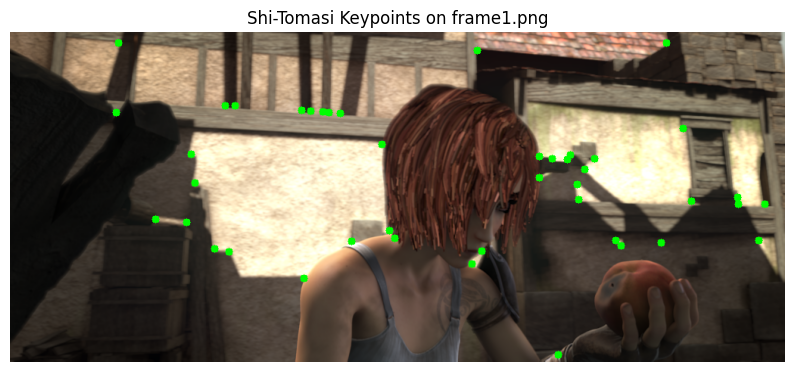

In [ ]:
#1.  Lucas-Kanade Implementation a) Feature Detection
import cv2
import numpy as np
import matplotlib.pyplot as plt
frame1_path = r"/content/MPI-Sintel-training_images/training/final/alley_1/frame_0001.png"
frame1 = cv2.imread(frame1_path)
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
# Parameters for Shi-Tomasi corner detection
feature_params = dict(maxCorners=100,
                      qualityLevel=0.3,
                      minDistance=7,
                      blockSize=7)

# Detect corners
p0 = cv2.goodFeaturesToTrack(gray1, mask=None, **feature_params)
# Draw circles on detected keypoints
for i in p0:
    x, y = i.ravel()
    cv2.circle(frame1, (int(x), int(y)), 5, (0, 255, 0), -1)


# Convert BGR to RGB for matplotlib
frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(10, 6))
plt.imshow(frame1_rgb)
plt.title("Shi-Tomasi Keypoints on frame1.png")
plt.axis('off')
plt.show()

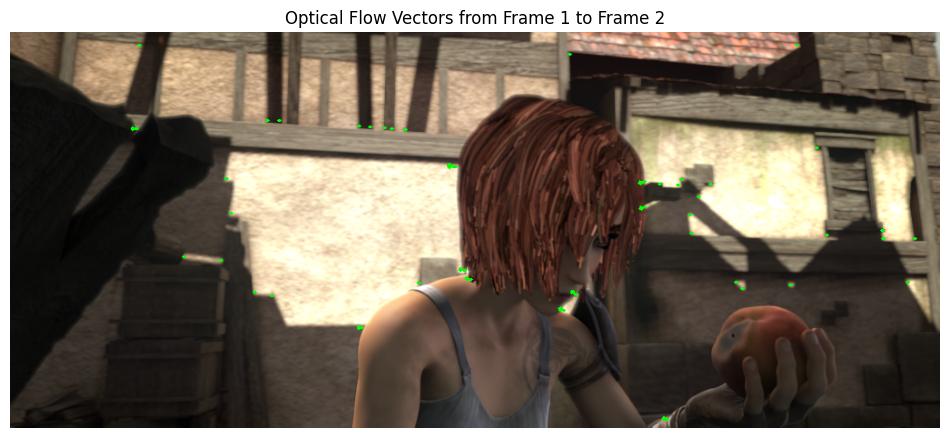

In [ ]:
#b) Optical Flow Calculation
import cv2
import numpy as np
import matplotlib.pyplot as plt
frame1_path = '/content/MPI-Sintel-training_images/training/final/alley_1/frame_0001.png'
frame2_path = '/content/MPI-Sintel-training_images/training/final/alley_1/frame_0002.png'

frame1 = cv2.imread(frame1_path)
frame2 = cv2.imread(frame2_path)

gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

p1, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)

# Select good points
good_new = p1[st == 1]
good_old = p0[st == 1]

# Create a copy of the original image to draw on
flow_image = frame1.copy()

# Draw arrows
for (new, old) in zip(good_new, good_old):
    a, b = new.ravel()
    c, d = old.ravel()
    cv2.arrowedLine(flow_image, (int(c), int(d)), (int(a), int(b)), (0, 255, 0), 2, tipLength=0.3)

# Convert BGR to RGB for matplotlib
flow_image_rgb = cv2.cvtColor(flow_image, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(12, 7))
plt.imshow(flow_image_rgb)
plt.title("Optical Flow Vectors from Frame 1 to Frame 2")
plt.axis('off')
plt.show()

In [ ]:
#c) Analysis
import numpy as np

# Compute displacement magnitudes
displacements = np.linalg.norm(p1 - p0, axis=1)
average_displacement = np.mean(displacements)
print("Average Displacement Magnitude:", average_displacement)



Average Displacement Magnitude: 1.4598716


| Limitation                        | Description                                                                                            |
| --------------------------------- | ------------------------------------------------------------------------------------------------------ |
| **Small Motions Only**            | Works well for small displacements. Fails for large or fast movements between frames.                  |
| **Requires Good Features**        | If the Shi-Tomasi detector misses keypoints in textureless regions, those areas aren't tracked.        |
| **Fails on Occlusion**            | If an object is occluded or leaves the frame, the tracking fails or gives noisy results.               |
| **Sensitive to Lighting Changes** | Since Lucas-Kanade assumes intensity consistency, changes in lighting can lead to incorrect flow.      |
| **Pyramidal Approximation**       | Although `cv2.calcOpticalFlowPyrLK` uses pyramids, extremely large movements may still break tracking. |


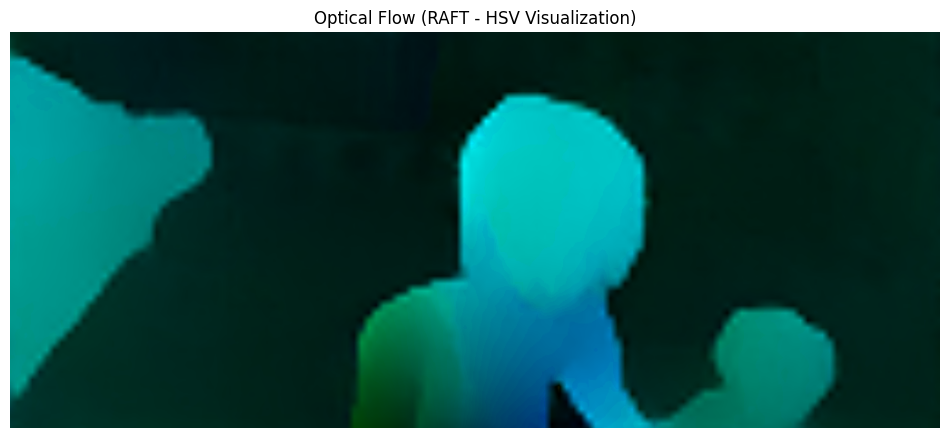

In [ ]:
# #2. FlowNET Implementation a) Model Setup:
# import torch
# from torchvision.models.optical_flow import raft_small, Raft_Small_Weights
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2
# import torch.nn.functional as F

# # Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load model and weights
# weights = Raft_Small_Weights.DEFAULT
# model = raft_small(weights=weights).to(device).eval()

# # Load frames
# frame1_path = '/content/MPI-Sintel-training_images/training/final/alley_1/frame_0001.png'
# frame2_path = '/content/MPI-Sintel-training_images/training/final/alley_1/frame_0002.png'

# img1 = Image.open(frame1_path).convert("RGB")
# img2 = Image.open(frame2_path).convert("RGB")

# # Get preprocessing transforms
# transform = weights.transforms()

# # Apply transform to both images together
# frame1, frame2 = transform(img1, img2)

# # Pad images to be divisible by 8
# def pad_to_multiple_of_8(tensor):
#     _, _, h, w = tensor.shape
#     pad_h = (8 - h % 8) % 8
#     pad_w = (8 - w % 8) % 8
#     return F.pad(tensor, (0, pad_w, 0, pad_h), mode='reflect')

# frame1 = pad_to_multiple_of_8(frame1.unsqueeze(0)).to(device)
# frame2 = pad_to_multiple_of_8(frame2.unsqueeze(0)).to(device)

# # Compute optical flow
# with torch.no_grad():
#     flow = model(frame1, frame2)

# # Remove padding from flow
# flow = flow[-1][0].cpu().numpy().transpose(1, 2, 0)  # (H, W, 2)
# flow = flow[:436, :1024]  # Crop back to original dimensions

# # Visualize optical flow as HSV
# def flow_to_hsv(flow):
#     fx, fy = flow[..., 0], flow[..., 1]
#     mag, ang = cv2.cartToPolar(fx, fy)
#     hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
#     hsv[..., 0] = ang * 180 / np.pi / 2
#     hsv[..., 1] = 255
#     hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
#     return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# flow_hsv = flow_to_hsv(flow)

# # Show output
# plt.figure(figsize=(12, 6))
# plt.imshow(flow_hsv)
# plt.title("Optical Flow (RAFT - HSV Visualization)")
# plt.axis('off')
# plt.show()

FlowNet (RAFT) Runtime: 4.7487 seconds


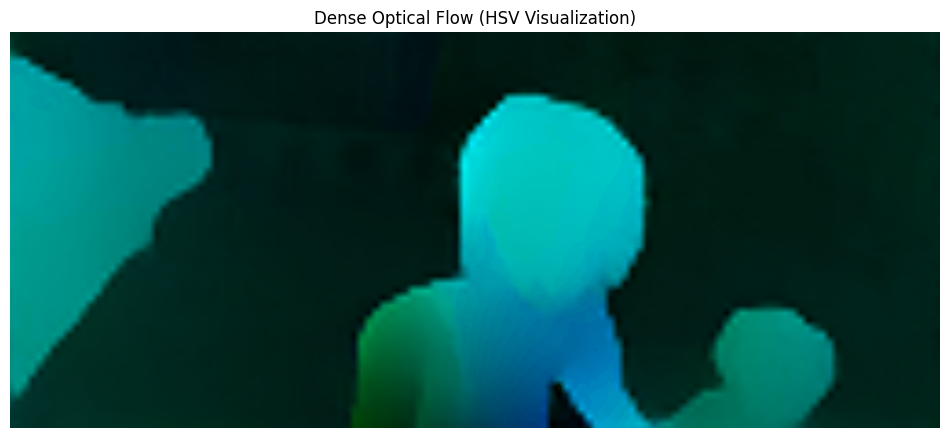

Lucas-Kanade Runtime: 0.0104 seconds
Lucas-Kanade Tracked Points: 43


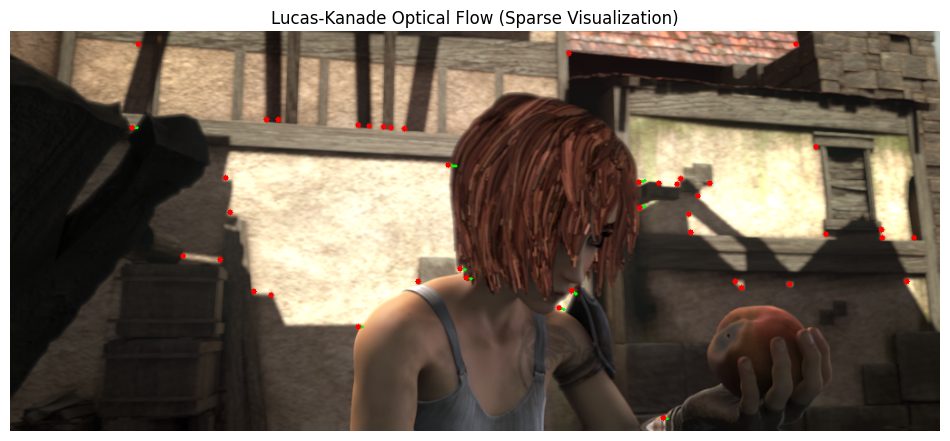

In [ ]:
# import torch
# from torchvision.models.optical_flow import raft_small, Raft_Small_Weights
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# import time

# # ---------------------- Helper Functions ----------------------

# def pad_to_divisible_by_8(image):
#     h, w = image.shape[:2]
#     pad_h = (8 - h % 8) % 8
#     pad_w = (8 - w % 8) % 8
#     return cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)

# def flow_to_hsv(flow):
#     u, v = flow[..., 0], flow[..., 1]
#     magnitude, angle = cv2.cartToPolar(u, v, angleInDegrees=True)

#     hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
#     hsv[..., 0] = angle / 2  # Hue
#     hsv[..., 1] = 255        # Saturation
#     hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)  # Value
#     return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# # ---------------------- Load and Preprocess Frames ----------------------

# # Use forward slashes or double backslashes
# path1 = "/content/MPI-Sintel-training_images/training/final/alley_1/frame_0001.png"
# path2 = "/content/MPI-Sintel-training_images/training/final/alley_1/frame_0002.png"

# frame1 = cv2.imread(path1)
# frame2 = cv2.imread(path2)

# # Check if frames were loaded
# if frame1 is None or frame2 is None:
#     raise FileNotFoundError("One or both image paths are incorrect or the files do not exist.")

# # Store original size for cropping later
# original_h, original_w = frame1.shape[:2]

# # Pad to divisible by 8
# frame1 = pad_to_divisible_by_8(frame1)
# frame2 = pad_to_divisible_by_8(frame2)

# # Convert to RGB and PIL
# frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
# frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
# frame1_pil = Image.fromarray(frame1_rgb)
# frame2_pil = Image.fromarray(frame2_rgb)

# # Load weights and transforms
# weights = Raft_Small_Weights.DEFAULT
# transform = weights.transforms()
# img1, img2 = transform(frame1_pil, frame2_pil)
# img1 = img1.unsqueeze(0)
# img2 = img2.unsqueeze(0)

# # ---------------------- RAFT (FlowNet-style) Inference ----------------------

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = raft_small(weights=weights, progress=False).to(device).eval()
# img1, img2 = img1.to(device), img2.to(device)

# # Time RAFT inference
# start_time = time.time()
# with torch.no_grad():
#     flow_preds = model(img1, img2)
# end_time = time.time()
# runtime_flownet = end_time - start_time
# print(f"FlowNet (RAFT) Runtime: {runtime_flownet:.4f} seconds")

# # Process final flow
# flow_up = flow_preds[-1].squeeze().cpu().numpy().transpose(1, 2, 0)
# flow_up = flow_up[:original_h, :original_w]

# # ---------------------- HSV Flow Visualization ----------------------

# flow_hsv = flow_to_hsv(flow_up)
# plt.figure(figsize=(12, 6))
# plt.imshow(flow_hsv)
# plt.title("Dense Optical Flow (HSV Visualization)")
# plt.axis('off')
# plt.show()

# # ---------------------- Lucas-Kanade (Sparse Flow) ----------------------

# gray1 = cv2.cvtColor(frame1[:original_h, :original_w], cv2.COLOR_BGR2GRAY)
# gray2 = cv2.cvtColor(frame2[:original_h, :original_w], cv2.COLOR_BGR2GRAY)

# # Feature detection
# feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
# p0 = cv2.goodFeaturesToTrack(gray1, mask=None, **feature_params)

# # LK parameters
# lk_params = dict(winSize=(15, 15), maxLevel=2,
#                  criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# # Time LK
# start_lk = time.time()
# p1, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)
# end_lk = time.time()
# runtime_lk = end_lk - start_lk
# print(f"Lucas-Kanade Runtime: {runtime_lk:.4f} seconds")
# print(f"Lucas-Kanade Tracked Points: {np.sum(st)}")

# # Draw LK optical flow tracks
# lk_visual = frame2.copy()
# for i, (new, old) in enumerate(zip(p1[st == 1], p0[st == 1])):
#     a, b = new.ravel()
#     c, d = old.ravel()
#     cv2.line(lk_visual, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
#     cv2.circle(lk_visual, (int(a), int(b)), 3, (0, 0, 255), -1)

# plt.figure(figsize=(12, 6))
# plt.imshow(cv2.cvtColor(lk_visual, cv2.COLOR_BGR2RGB))
# plt.title("Lucas-Kanade Optical Flow (Sparse Visualization)")
# plt.axis('off')
# plt.show()


In [ ]:
# 2. FlowNET Implementation a) Model Setup
import torch
from torchvision.models.optical_flow import raft_small, Raft_Small_Weights
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time


def pad_to_divisible_by_8(image):
    h, w = image.shape[:2]
    pad_h = (8 - h % 8) % 8
    pad_w = (8 - w % 8) % 8
    return cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)

def flow_to_hsv(flow):
    u, v = flow[..., 0], flow[..., 1]
    magnitude, angle = cv2.cartToPolar(u, v, angleInDegrees=True)

    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = angle / 2  # Hue
    hsv[..., 1] = 255        # Saturation
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)  # Value
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


# NOTE: Adjust the paths based on your environment
path1 = "/content/MPI-Sintel-training_images/training/final/alley_1/frame_0001.png"
path2 = "/content/MPI-Sintel-training_images/training/final/alley_1/frame_0002.png"

frame1 = cv2.imread(path1)
frame2 = cv2.imread(path2)

if frame1 is None or frame2 is None:
    raise FileNotFoundError("One or both image paths are incorrect or the files do not exist.")

original_h, original_w = frame1.shape[:2]
frame1 = pad_to_divisible_by_8(frame1)
frame2 = pad_to_divisible_by_8(frame2)

frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
frame1_pil = Image.fromarray(frame1_rgb)
frame2_pil = Image.fromarray(frame2_rgb)

# Load RAFT-small model and weights
weights = Raft_Small_Weights.DEFAULT
transform = weights.transforms()
img1, img2 = transform(frame1_pil, frame2_pil)
img1 = img1.unsqueeze(0)
img2 = img2.unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = raft_small(weights=weights, progress=False).to(device).eval()
img1, img2 = img1.to(device), img2.to(device)


Max flow magnitude: 9.302631


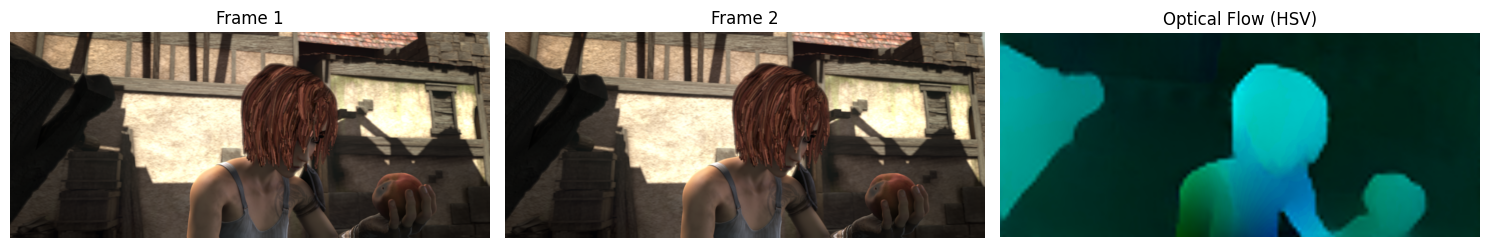

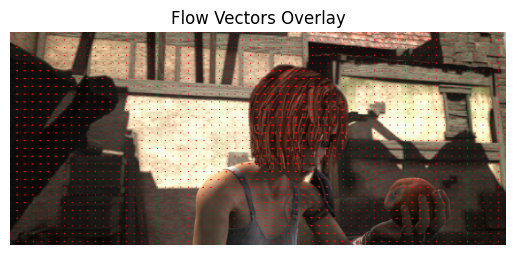

In [8]:
import torch
from torchvision.models.optical_flow import raft_small, Raft_Small_Weights
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def pad_to_divisible_by_8(image):
    h, w = image.shape[:2]
    pad_h = (8 - h % 8) % 8
    pad_w = (8 - w % 8) % 8
    return cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)

def flow_to_hsv(flow):
    u, v = flow[..., 0], flow[..., 1]
    magnitude, angle = cv2.cartToPolar(u, v, angleInDegrees=True)
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = angle / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def show_quiver_on_image(flow, base_image, stride=16):
    h, w = flow.shape[:2]
    y, x = np.mgrid[0:h:stride, 0:w:stride]
    fx, fy = flow[::stride, ::stride, 0], flow[::stride, ::stride, 1]
    plt.imshow(base_image)
    plt.quiver(x, y, fx, fy, color='red', angles='xy', scale_units='xy', scale=1)
    plt.title("Flow Vectors Overlay")
    plt.axis("off")
    plt.show()

def main():
    # Use two frames with significant motion
    path1 = "/content/MPI-Sintel-training_images/training/final/alley_1/frame_0001.png"
    path2 = "/content/MPI-Sintel-training_images/training/final/alley_1/frame_0002.png"

    frame1 = cv2.imread(path1)
    frame2 = cv2.imread(path2)
    if frame1 is None or frame2 is None:
        raise FileNotFoundError("One or both image paths are incorrect or the files do not exist.")

    original_h, original_w = frame1.shape[:2]
    frame1 = pad_to_divisible_by_8(frame1)
    frame2 = pad_to_divisible_by_8(frame2)

    frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

    frame1_pil = Image.fromarray(frame1_rgb)
    frame2_pil = Image.fromarray(frame2_rgb)

    # Load RAFT-small model with weights
    weights = Raft_Small_Weights.DEFAULT
    transform = weights.transforms()
    img1, img2 = transform(frame1_pil, frame2_pil)
    img1 = img1.unsqueeze(0)
    img2 = img2.unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = raft_small(weights=weights, progress=False).to(device).eval()

    img1, img2 = img1.to(device), img2.to(device)

    # Run model and get final flow
    with torch.no_grad():
        list_of_flows = model(img1, img2)
        flow = list_of_flows[-1][0].permute(1, 2, 0).cpu().numpy()

    # Resize flow to original size
    flow_resized = cv2.resize(flow, (original_w, original_h), interpolation=cv2.INTER_LINEAR)

    # Debug: Print maximum flow magnitude
    magnitude = np.sqrt(np.sum(flow_resized ** 2, axis=2))
    print("Max flow magnitude:", np.max(magnitude))

    # Convert to HSV image for visualization
    flow_hsv = flow_to_hsv(flow_resized)

    # Plot results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(frame1_rgb)
    plt.title("Frame 1")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(frame2_rgb)
    plt.title("Frame 2")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(flow_hsv)
    plt.title("Optical Flow (HSV)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Optional: Overlay flow vectors
    show_quiver_on_image(flow_resized, frame1_rgb)

if __name__ == "__main__":
    main()


FlowNet (RAFT) Runtime: 4.7840 seconds


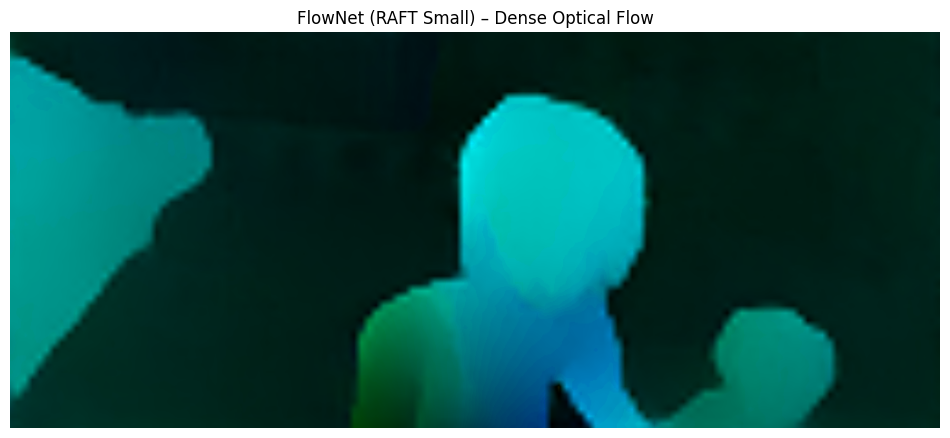

In [ ]:
#b) Dense Optical Flow Estimation
# ---------------------- RAFT Flow Estimation ----------------------

start_time = time.time()
with torch.no_grad():
    flow_preds = model(img1, img2)
end_time = time.time()
runtime_flownet = end_time - start_time
print(f"FlowNet (RAFT) Runtime: {runtime_flownet:.4f} seconds")

# Get final flow prediction and crop to original image size
flow_up = flow_preds[-1].squeeze().cpu().numpy().transpose(1, 2, 0)
flow_up = flow_up[:original_h, :original_w]

# ---------------------- HSV Visualization ----------------------

flow_hsv = flow_to_hsv(flow_up)
plt.figure(figsize=(12, 6))
plt.imshow(flow_hsv)
plt.title("FlowNet (RAFT Small) – Dense Optical Flow")
plt.axis('off')
plt.show()


Lucas-Kanade Runtime: 0.0020 seconds
Lucas-Kanade Tracked Points: 43


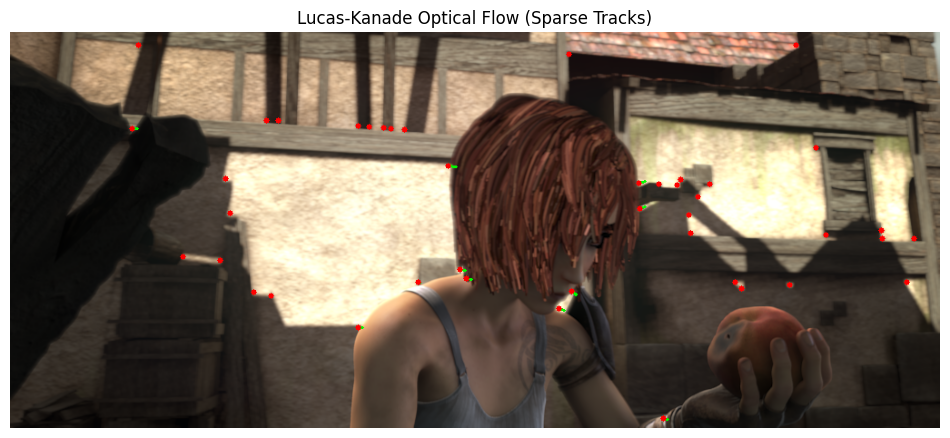

In [ ]:
#c) Analysis
# ---------------------- Lucas-Kanade Optical Flow ----------------------

gray1 = cv2.cvtColor(frame1[:original_h, :original_w], cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2[:original_h, :original_w], cv2.COLOR_BGR2GRAY)

# Feature detection
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
p0 = cv2.goodFeaturesToTrack(gray1, mask=None, **feature_params)

# LK parameters
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

start_lk = time.time()
p1, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)
end_lk = time.time()
runtime_lk = end_lk - start_lk

print(f"Lucas-Kanade Runtime: {runtime_lk:.4f} seconds")
print(f"Lucas-Kanade Tracked Points: {np.sum(st)}")

# ---------------------- LK Visualization ----------------------

lk_visual = frame2[:original_h, :original_w].copy()
for i, (new, old) in enumerate(zip(p1[st == 1], p0[st == 1])):
    a, b = new.ravel()
    c, d = old.ravel()
    cv2.line(lk_visual, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
    cv2.circle(lk_visual, (int(a), int(b)), 3, (0, 0, 255), -1)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(lk_visual, cv2.COLOR_BGR2RGB))
plt.title("Lucas-Kanade Optical Flow (Sparse Tracks)")
plt.axis('off')
plt.show()


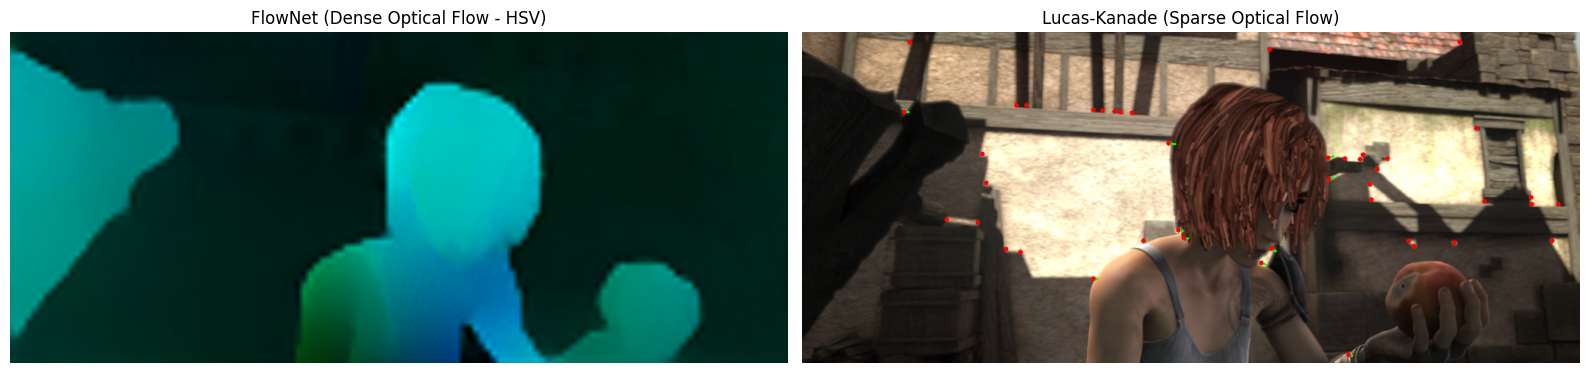

In [ ]:
#3. Comparative Analysis
# ---------------------- Side-by-Side Comparison ----------------------

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# RAFT / FlowNet (Dense Optical Flow)
axs[0].imshow(flow_hsv)
axs[0].set_title("FlowNet (Dense Optical Flow - HSV)")
axs[0].axis("off")

# Lucas-Kanade (Sparse Flow)
axs[1].imshow(cv2.cvtColor(lk_visual, cv2.COLOR_BGR2RGB))
axs[1].set_title("Lucas-Kanade (Sparse Optical Flow)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


Qualitative Analysis:

1. **Density of Vectors**:
   - FlowNet (RAFT) generates a dense optical flow field, estimating motion at *every pixel*.
   - Lucas-Kanade only tracks motion at a few feature points, making it sparse and limited in scope.

2. **Textureless Regions**:
   - FlowNet is able to capture motion in flat or low-texture regions (e.g., walls, floors) where Lucas-Kanade fails to find good features.

3. **Large Displacements**:
   - Lucas-Kanade struggles with large inter-frame motion due to its local window-based tracking.
   - FlowNet captures larger movements accurately due to its global learning-based approach.

4. **Robustness**:
   - FlowNet is more robust to lighting and texture variation because it's trained on large datasets.
   - Lucas-Kanade is sensitive to noise and blur.

Conclusion:
→ **Use FlowNet** for dense, robust flow when computation cost is not a limitation.  
→ **Use Lucas-Kanade** for lightweight tracking on small motion and good-texture features.
